In [3]:
import json 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.utils.data import DataLoader, Dataset

c:\Users\sokmo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\sokmo\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
def readJson(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    return data

In [5]:
# shapes:
# 0 - example/test
# 1 - samples
# 2 - input/output
# 4 - height
# 5 - width
# 6 - color 
# max width and height of all samples: 30x30
class ARCDataset(Dataset):
    def __init__(self, json_files):
        self.json_files = json_files

    def __len__(self):
        return len(self.json_files)
    
    def __getitem__(self, index):
        file_name = self.json_files[index]
        arc_json_data = readJson(file_name)

        for s in arc_json_data['train']:
            s['input'] = self.resize(s['input'])
            s['output'] = self.resize(s['output'])

        for s in arc_json_data['test']:
            s['input'] = self.resize(s['input'])
            s['output'] = self.resize(s['output'])

        return {
            'train': t.tensor([[s['input'], s['output']]for s in arc_json_data['train']]),
            'test': t.tensor([[s['input'], s['output']]for s in arc_json_data['test']]),
        }

    def resize(self, array):
        result = np.zeros((30, 30), dtype=np.int8)
        array = np.array(array, dtype=np.int8)
        h, w = array.shape
        result[:h, :w] = array
        return result

In [6]:
cmap = ListedColormap(['#000000', 
                       '#1e92fe', 
                       '#f83c30', 
                       '#4ecd30', 
                       '#fedc01', 
                       '#999999', 
                       '#e53aa3', 
                       '#fe841b', 
                       '#86d9f1', 
                       '#bcbd22'])

def showTrainingImages(sample, width=8, height=7):
    trains = sample['train'][0]
    tests = sample['test'][0]

    rows = max(len(trains), len(tests))
    cols = 4
    _, axs = plt.subplots(rows, cols, figsize=(width, height))

    axs[0, 0].set_title('Train Input')
    axs[0, 1].set_title('Train Output')
    axs[0, 2].set_title('Test Input')
    axs[0, 3].set_title('Test Output')

    for rows in axs:
        for ax in rows:
            ax.axis('off')
    
    for train, i in zip(trains, range(len(trains))):
        axs[i, 0].imshow(train[0], cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].imshow(train[1], cmap=cmap, vmin=0, vmax=9)

    for test, i in zip(tests, range(len(tests))):
        axs[i, 2].imshow(test[0], cmap=cmap, vmin=0, vmax=9)
        axs[i, 3].imshow(test[1], cmap=cmap, vmin=0, vmax=9)

    plt.show()

In [90]:
training_dir = './data/training/'
train_file_names = [os.path.join(training_dir, file_name)
                    for file_name in os.listdir(training_dir)]

# training_ds = ARCDataset(train_file_names)
training_ds = ARCDataset([training_dir + '06df4c85.json'])
dl = DataLoader(training_ds, batch_size=1, shuffle=False)
sample = next(iter(dl))

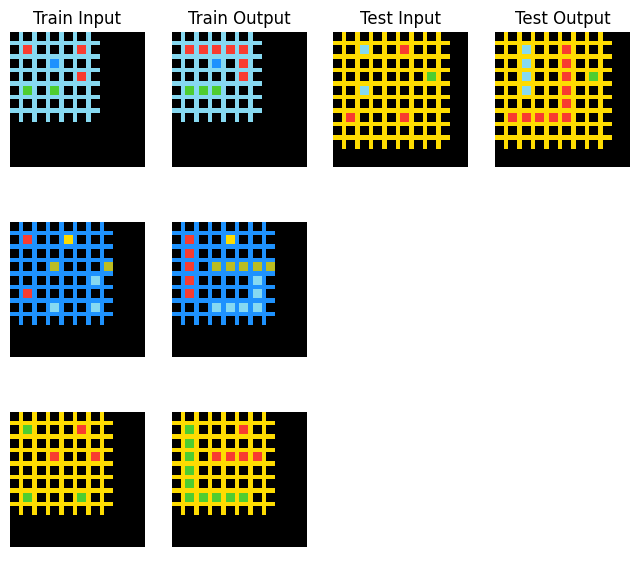

In [91]:
sample = next(iter(dl))
showTrainingImages(sample)

In [114]:
class Cluster:
    def __init__(self, points):
        self.points = points
        self.centroid = self.calculateCentroid()
    
    def calculateCentroid(self):
        return np.mean(self.points, axis=0)

def getFloodFillClusters(img):
    clusters = []
    visited = np.zeros_like(img)

    temp_cluster = []
    def floodFill(prev_val, x, y):
        if x < 0 or y < 0 or x >= img.shape[0] or y >= img.shape[1]: return
        if visited[x, y]: return
        if img[x, y] != prev_val: return

        visited[x, y] = 1
        temp_cluster.append((x, y))
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            floodFill(prev_val, x + dx, y + dy)

    for y in range(30):
        for x in range(30):
            temp_cluster = []
            floodFill(img[x, y], x, y)
            if len(temp_cluster) > 0:
                cluster = Cluster(np.array(temp_cluster))
                clusters.append(cluster)

    return clusters

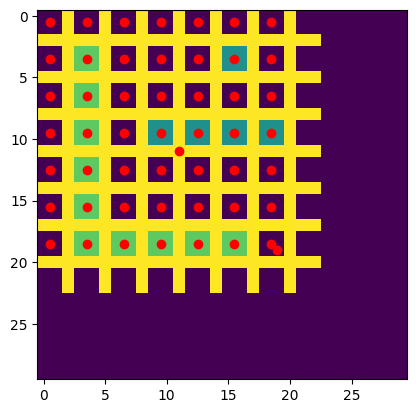

In [116]:
img = sample['train'][0][2, 1]
clusters = getFloodFillClusters(img)

plt.imshow(img)
for cluster in clusters:
    plt.scatter(cluster.centroid[0], cluster.centroid[1], c='r')
plt.show()